## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt

## Utils

In [ ]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(source[idx[i], from_:to_], c='b')
            axs[r,c].plot(prediction[idx[i], from_:to_], c='r')

            i += 1
    fig.tight_layout()
    plt.show()

In [ ]:
def plot_shape_function(d, F1, F2, nrow=5, ncol=5):
    n = F1.shape[1]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            if F2 is not None:
                axs[r,c].scatter(d, F1[:, idx[i]], c='b')
                axs[r,c].scatter(d, F2[:, idx[i]], c='r')
            else:
                axs[r,c].scatter(d, F1[:, idx[i]])
            i += 1
    fig.tight_layout()
    plt.show()

In [ ]:
## Colors
# import matplotlib.colors as mcolors
# size = out[2].shape[1]
# colors = list(mcolors.CSS4_COLORS.keys())
# indices = random.choices(range(len(colors)), k=size)

In [ ]:
def scale(X, max_, min_):
    X_std = (X - X.min(axis=1).reshape(-1,1)) / ((X.max(axis=1) - X.min(axis=1)).reshape(-1,1))
    X_std = X_std * (max_ - min_) + min_
    return X_std

## Check data

In [ ]:
data = np.load('data/nst_sim.npy')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data[2, :5000])

## Forecasting

In [ ]:
sim = load_pickle('output/sim_e50.pickle')

In [ ]:
sim[0].shape, sim[1].shape, sim[2].shape

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(sim[0][10, -200:], c='b')
plt.plot(sim[1][10, -200:], c='r')

plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 0, 3000)

## Shape Function

In [ ]:
ids, d, _ = load_pickle('data/sample.pickle')
d_norm = d
F = np.log(d_norm+1)

In [ ]:
l = 200
plt.figure(figsize=(20,10))
plt.scatter(d_norm[:l], F[:l, ], c='b')
plt.scatter(d_norm[:l], sim[2][:l, 0], c='r')
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

## Baselines Comparison

In [2]:
dataset = 'sim'
horizon = 1

In [3]:
data = np.load(f'data/{dataset}.npy')
loc, n = data.shape
print(loc, n)

30 500


In [4]:
#  Scale data and horizon
# data = scale(data, 0.3, 0)

In [5]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [6]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [7]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
    print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

## Visualization

In [33]:
names = ['DC-RNN', 'FC-GAGA', 'GMAN', 'ConvLSTM']
preds = []
labels = []
for name in names:
    print(name)
    p, l = load_outputs(f'{name}/data/{dataset}/full_predictions.npz', n, horizon, loc)
    preds.append(p)
    labels.append(l)

DC-RNN
(1, 500, 30) (500, 1, 30) (500, 1, 30) // (30, 500) (30, 500)
FC-GAGA
(499, 30, 1, 1) (499, 30, 1) (499, 30, 1) // (30, 500) (30, 500)
GMAN
(499, 1, 30) (499, 1, 30) (499, 1, 30) // (30, 500) (30, 500)
ConvLSTM
(499, 1, 10, 3) (499, 1, 10, 3) (499, 1, 10, 3) // (30, 500) (30, 500)


In [34]:
def compute_metrics(name, p, l, horizon, size = None):
    if size:
        p = p[:, -size:]
        l = l[:, -size:]
    # Mean absolute error
    mae = (np.abs(p - l) / horizon).mean()

    # Mean Absolute Percentage Error
    mape = (np.abs((l - p) / (l+1e-10)) * (100 / horizon)).mean()

    # Root Mean Squared Error
    rmse = ((p - l)**2 / horizon).mean(-1)
    rmse = np.sqrt(rmse).mean()

    print(f"{name} & {mae:.4f} & {mape/1000:.2f}\\times10^3 & {rmse:.4f} \\\\")

In [35]:
for i in range(4):
    compute_metrics(names[i], preds[i], labels[i], horizon, 200)
    print("=" * 100)

DC-RNN & 0.0812 & 0.51\times10^3 & 0.1024 \\
FC-GAGA & 0.0898 & 0.72\times10^3 & 0.1133 \\
GMAN & 0.6157 & 7.91\times10^3 & 0.7685 \\
ConvLSTM & 0.2935 & 5.80\times10^3 & 0.3280 \\


In [36]:
sim = load_pickle('output/sim_ep500.pickle')
compute_metrics('Shape function', sim[1], data , 1, 200)

Shape function & 0.0806 & 0.48\times10^3 & 0.1017 \\


In [ ]:
for i in range(4):
    print(labels[i][0, :5])
data[0, :5]

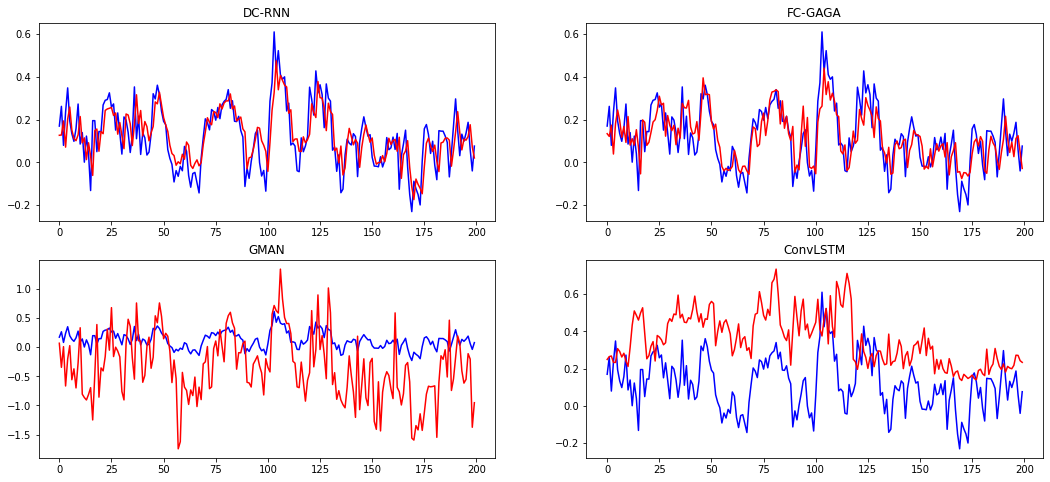

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
i = 0
location = 10
for r in range(2):
    for c in range(2):
        axs[r,c].plot(labels[i][location, -200:], color='blue')
        axs[r,c].plot(preds[i][location, -200:], color='red')
        axs[r,c].title.set_text(names[i])
        i += 1


In [ ]:
plt.figure(figsize=(18,8))
plt.plot(sim[0][location, -200:], c='b')
plt.plot(sim[1][location, -200:], c='r')
plt.show()